# Clustering with scikit-learn

<img src="https://media.giphy.com/media/G9qfCvxlwGAaQ/giphy.gif" align="right" width="250" />

There are many clustering methods out there, and `scikit-learn` (or `sklearn` for short) already provides support for [a good deal of them](https://scikit-learn.org/stable/modules/clustering.html). We'll go through some short examples to (sk)learn to cluster!

For this exercise, I want you to become the very best, like no one ever was! That's right, let's catch some Pokémon!

The goal of this exercise is to:
- reduce your anxiety of having to choose Pokémon by letting an algorithm do it for you
- determine similar Pokémon based on **height** and **weight**
- choose 6 final Pokémon that are as **diverse as possible**

Let's start by importing our dataset:

In [3]:
import pandas as pd

pokemon = pd.read_csv("./assets/pokemon.csv")

In [ ]:
pokemon.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [4]:
pokemon.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

Alright, seems to be in order! Now let's visualize these Pokémon using `matplotlib`. Let's see if our relevant data contains invalid entries.

In [5]:
# check number of invalid metric entries
print(pokemon['weight_kg'].isnull().sum())
print(pokemon['height_m'].isnull().sum())

20
20


Seems that there are some weightless/heightless Pokémon in our dataset! It's going to be hard clustering those, so let's kick them out!

In [6]:
# drop rows containing null values for weight or height
pokemon = pokemon.dropna(axis=0, subset=['weight_kg'])
pokemon = pokemon.dropna(axis=0, subset=['height_m'])

# adjusting index
pokemon = pokemon.reset_index(drop=True)

Text(0, 0.5, 'Pokémon height [m]')

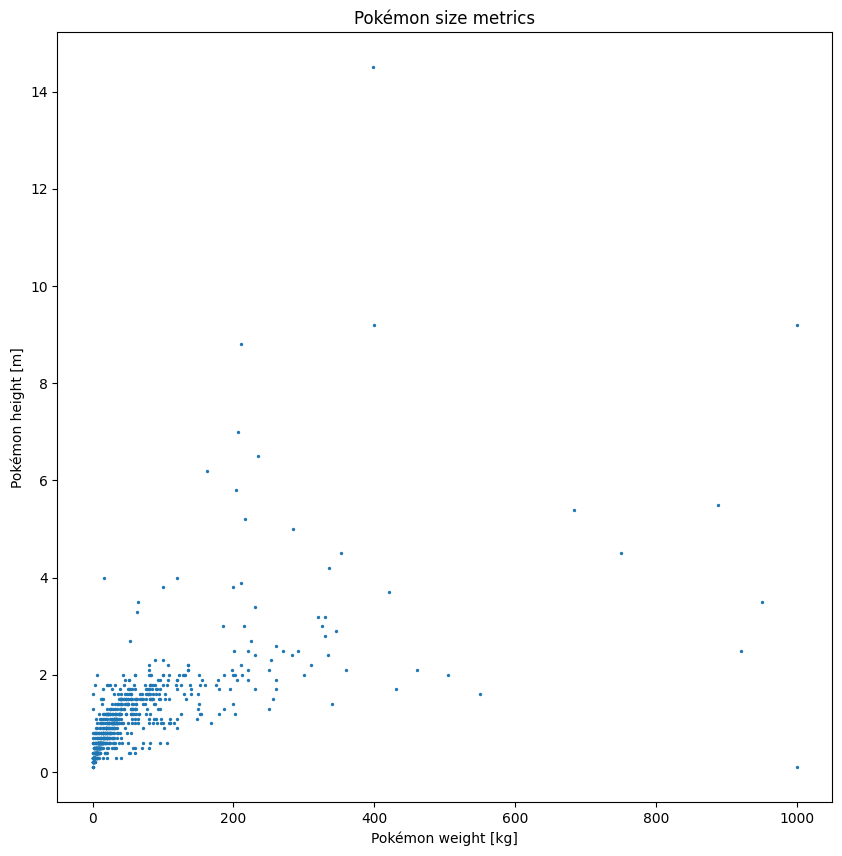

In [8]:
import matplotlib.pyplot as plt

# plot size metrics
fig=plt.figure(figsize=(10,10))
plt.scatter(pokemon['weight_kg'], pokemon['height_m'], s=2)
plt.title("Pokémon size metrics")
plt.xlabel("Pokémon weight [kg]")
plt.ylabel("Pokémon height [m]")

Let's zoom in a bit

(0.0, 2.5)

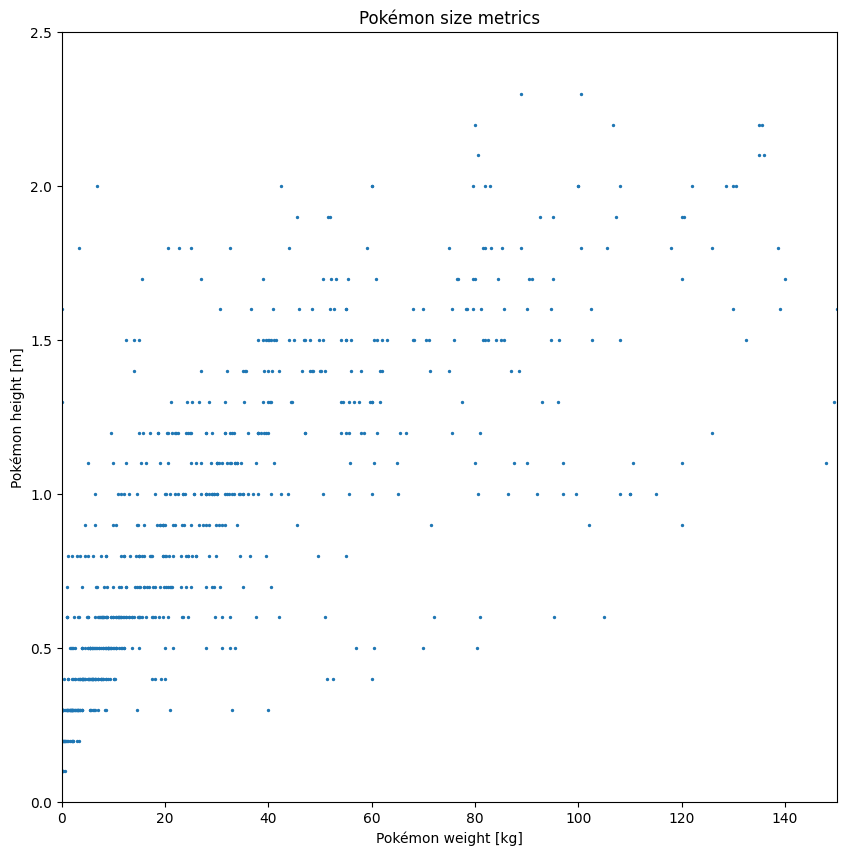

In [9]:
# plot size metrics
fig=plt.figure(figsize=(10,10))
plt.scatter(pokemon['weight_kg'], pokemon['height_m'], s=2)
plt.title("Pokémon size metrics")
plt.xlabel("Pokémon weight [kg]")
plt.ylabel("Pokémon height [m]")

# limit plot
plt.xlim([0, 150])
plt.ylim([0, 2.5])

All these Pokémon look the same! Let's give them some colors according to their primary type.

(0.0, 2.5)

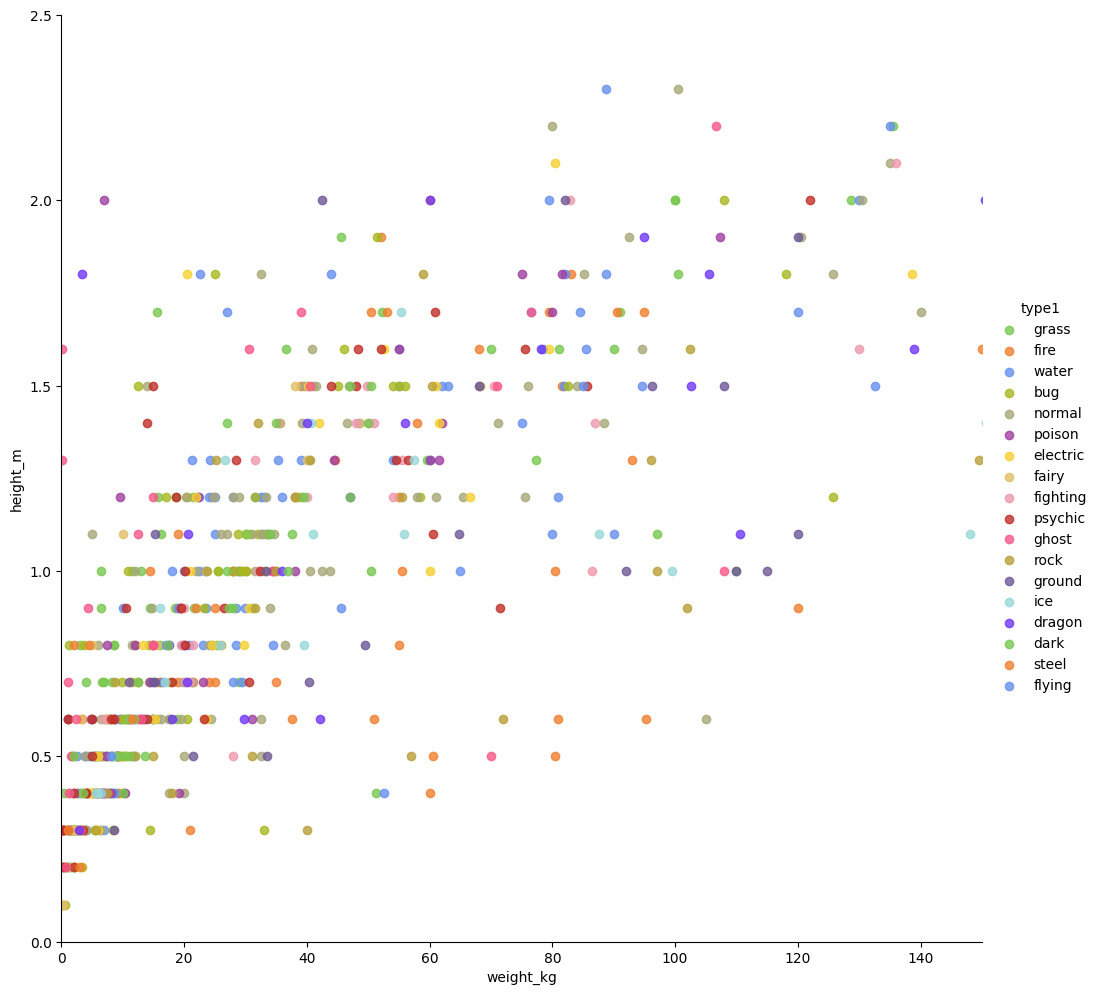

In [10]:
import seaborn as sns

# define colors
pokemon_type_colors = ['#78C850',  # Grass
                       '#F08030',  # Fire
                       '#6890F0',  # Water
                       '#A8B820',  # Bug
                       '#A8A878',  # Normal
                       '#A040A0',  # Poison
                       '#F8D030',  # Electric
                       '#E0C068',  # Ground
                       '#EE99AC',  # Fairy
                       '#C03028',  # Fighting
                       '#F85888',  # Psychic
                       '#B8A038',  # Rock
                       '#705898',  # Ghost
                       '#98D8D8',  # Ice
                       '#7038F8',  # Dragon
                   ]

# plot data with the type color palette
sns.lmplot(x='weight_kg', y='height_m',  height=10, data=pokemon,
           fit_reg=False, # No regression line
           hue='type1', palette= pokemon_type_colors)

# limit plot
plt.xlim([0, 150])
plt.ylim([0, 2.5])

How colorful! It's time to cluster these Pokémon with **k-means**. Why k-means? Well, for one, it requires a **centroid number** argument, which we know beforehand: it's 6, the number of Pokémon we're looking for. 

We'll have to keep in mind that k-means is **non-deterministic** since its initialization influences the final solution. The results we get are semi-random.

Using **k-means** means we are **maximizing in-cluster similarity** while **minimizing cluster-to-cluster similarity**.

In [11]:
from sklearn.cluster import KMeans

# number of Pokémon clusters
team_size = 6

# make new dataframe with relevant metrics
pokemon_metrics = pokemon['weight_kg'].to_frame().join(pokemon['height_m'].to_frame())

# z-score normalisation
pokemon_metrics_normalized=(pokemon_metrics-pokemon_metrics.mean())/pokemon_metrics.std()
pokemon_metrics_normalized = pokemon_metrics_normalized.rename(columns={'weight_kg': 'weight_zscore',
                                                                        'height_m':'height_zscore'})

# fit a kmeans object to the dataset
kmeans = KMeans(n_clusters=team_size, init='k-means++').fit(pokemon_metrics_normalized)

# clusters is an attribute of the object
cluster_centers = kmeans.cluster_centers_

# add cluster index to dataframe
cluster_labels = pd.Series(kmeans.labels_, name='cluster')
pokemon_metrics_normalized = pokemon_metrics_normalized.join(cluster_labels.to_frame())

c:\Users\becode\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Let's see the result! We've used **z-score normalization** on the data to avoid **one dimension dominating the other dimensions**. A dataset where one metric is of a vastly different order than the other metrics is **ill-posed** and needs normalization.

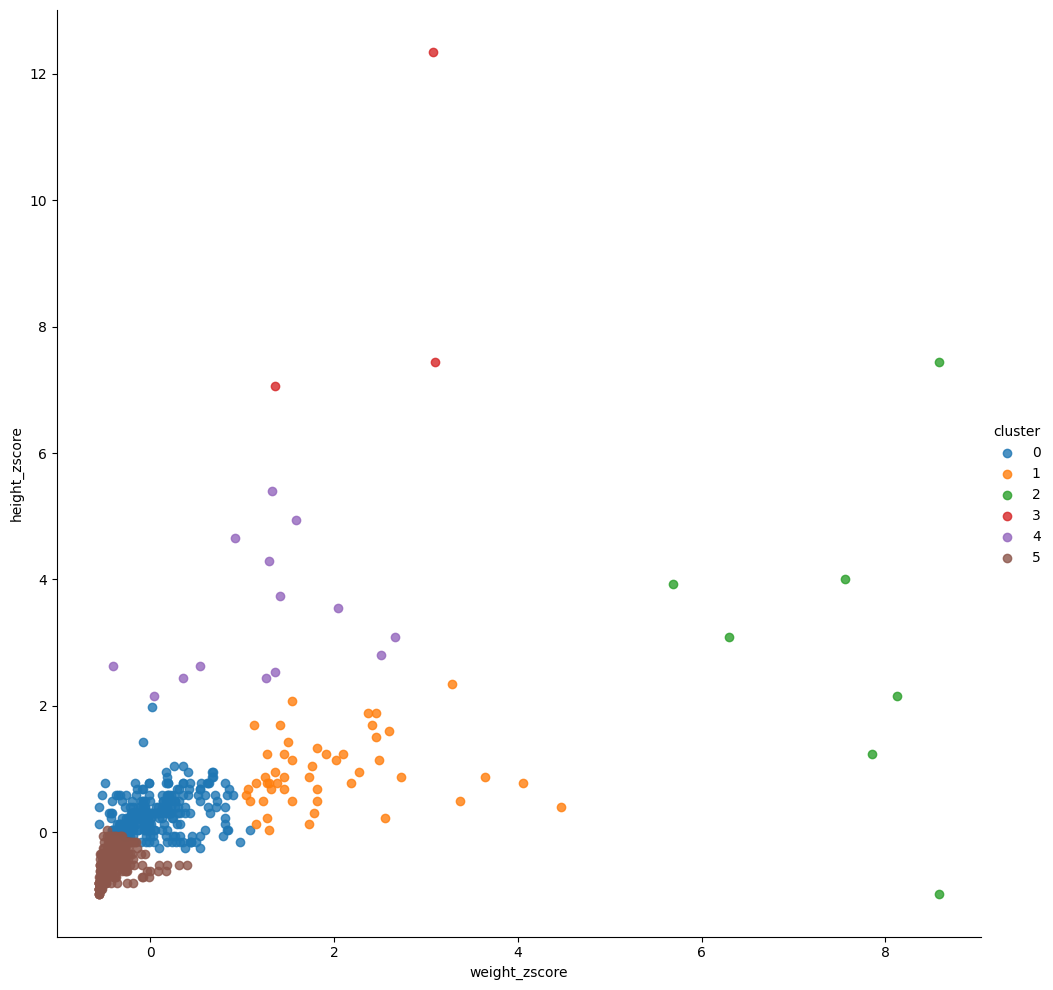

In [12]:
sns.lmplot(x='weight_zscore', y='height_zscore',  height=10, data=pokemon_metrics_normalized,
           fit_reg=False, hue='cluster')

Alright! We've made 6 clusters! But how do we pick our Pokémon?

As stated before, clustering with the **k-means** method, we ensure **cluster-to-cluster dissimilarity** and **cluster-member similarity**. But what about similarity of a member of one cluster, with the totality of a whole other cluster?

Well, as you can see in the above plot, this varies between members of the same cluster. For instance, at the boundary of two clusters, the difference between any two members of those two clusters is very minimal.

What does this mean for us Pokémon trainers? It means we still have to **maximize member-to-every-other-cluster dissimilarity** to determine a truly dissimilar Pokémon team!

This means we'll check every member in a cluster and compare it to the centroids of the other clusters. The member furthest away from all other clusters is approximately **the most dissimilar to all other Pokémon**.

Wait, what do you mean "approximately"? Well, we could compare every member of the dataset to every other member of the whole dataset, but you can imagine this doesn't scale really well. For this reason, we **reduced** the problem **complexity** by using clustering!

In [14]:
import numpy as np        
        
def distance_to_other_clusters(pokemon):
    if not pokemon.loc[pokemon.isin(['weight_zscore', 'height_zscore', 'cluster'])].all():
        return
    metric = np.array([pokemon['weight_zscore'], pokemon['height_zscore']])
    cluster_number = round(pokemon['cluster'])
    distance = 0
    for cluster_index in range(0, len(cluster_centers)):
        if cluster_index == cluster_number:
            continue
        center = cluster_centers[cluster_index]
        distance += np.sqrt(sum(np.square(metric - center)))
    return distance

# evaluate all Pokémon
pokemon_dissimilarity = pokemon_metrics_normalized.apply(distance_to_other_clusters, axis=1)
pokemon_dissimilarity = pokemon_dissimilarity.rename('dissimilarity')

# join to other metrics
pokemon_processed = pokemon_metrics_normalized.join(pokemon_dissimilarity.to_frame()).join(pokemon['name'].to_frame())

# pick most dissimilar Pokémon per cluster
chosen_pokemon = pd.DataFrame()
for cluster_index in range(0, len(cluster_centers)):
    pokemon_cluster = pokemon_processed[pokemon_processed['cluster'] == cluster_index]
    chosen_pokemon = chosen_pokemon.append(pokemon_cluster[pokemon_cluster['dissimilarity']==pokemon_cluster['dissimilarity'].max()])


AttributeError: 'DataFrame' object has no attribute 'append'

In [15]:
chosen_pokemon

""


There they are, the chosen few! The most **physically diverse Pokémon** we could find!

But are these really the most diverse Pokémon? We have all this **unused data** from out dataset like **combat stats** and **Pokémon types**. To get the real most diverse team out there, we'll have to use this data as well.

The journey to find the most diverse team continues, in the **[drills](./2.clustering_drills.ipynb)**!

![sunset](https://media.giphy.com/media/l0HluqguCBcvwCvBu/giphy.gif)